In [1]:
import tensorflow as tf
#import wave
import glob
import scipy.io.wavfile as wavfile
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from tqdm import tqdm_notebook
%matplotlib inline

In [11]:
global SMP_RATE, MAX_INT16, N_LAY
#SMP_RATE = 16000
SMP_RATE = 16384
MAX_INT16 = 32768
cycle_reg = .001

In [3]:
def getWaveName(wavepath):
    return wavepath.split('/')[-1]

def findWave(wavefile,path):
    r = glob.glob(path+wavefile)
    return r[0]

In [4]:
# fpath = '../../cmu_artic/female_us_slt/' #desktop
# mpath = '../../cmu_artic/male_us_bdl/' #desktop
fpath = '../data/female_us/'
mpath = '../data/male_us/'

# Hacky parallel dataset

In [5]:
# map male to female
m2f = dict()
for i in glob.glob(mpath+'/*.wav'):
    m2f[i]=findWave(getWaveName(i),fpath)

In [6]:
m2f.keys()[0]

'../data/male_us/arctic_a0209.wav'

# Bin before hand

In [12]:
bin_size_x = (1,5)
bin_size_y = (1,5)

In [13]:
bin_mapping = {}
for filename in glob.glob(mpath+'*.wav'):
    fm, wav_data = wavfile.read(filename)
    size = wav_data.shape[0]/(1.0*fm)
    if size < bin_size_x[1] and size > bin_size_x[0]:
        fm2, wav_data2 = wavfile.read(m2f[filename])
        size2 = wav_data2.shape[0]/(1.0*fm2)
        if size2 < bin_size_x[1] and size2 > bin_size_x[0]:
            bin_mapping[filename] = m2f[filename]

In [14]:
len(bin_mapping)

1121

# Sec to Samples

In [15]:
def sec2samp(sec,smp_rate):
    return int(sec*smp_rate)

# Padding 

so all samples are same length

In [16]:
def padTo(x,size,kind='SYM'):
    """
    Expects 1D array
    """
    assert kind in ['LEFT','RIGHT','SYM']
    if kind == 'LEFT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((pad,x),axis=0)
    elif kind == 'RIGHT':
        pad = np.zeros(size-len(x),dtype=x.dtype)
        r=np.concatenate((x,pad),axis=0)
    elif kind == 'SYM':
        padl = np.zeros((size-len(x))/2,dtype=x.dtype)
        padr = np.zeros((size-len(x))/2+(size-len(x))%2,dtype=x.dtype)
        r = np.concatenate((padl,x,padr),axis=0)
    return r

# Batch Generator

convolution expects data of shape (batchsize,height,width,inchannel)

Data should be of shape (batchsize,height=1,time_length (this is width),inchannel=1)

In [17]:
class Batch(object):
    def __init__(self,mapping,bin_max,batch_size=1):
        self.mapping = mapping
        self.bin_max = bin_max
        self.batch_size = batch_size
        self.seq_size = self.bin_max*SMP_RATE
        self.shape = (self.batch_size,1,self.seq_size,1)
        self.x_list = mapping.keys()
        self.size = len(self.x_list) #data size
        self.cursors = [(self.size//self.batch_size)*i for i in range(self.batch_size)]
        
    def getBatch(self):
        #get the file names
        x_path = [self.x_list[c] for c in self.cursors]
        y_path = [self.mapping[xp] for xp in x_path]
        
        #Get the x,y files and pad
        x = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        y = np.empty(shape=(self.batch_size,1,self.seq_size,1))
        for i,(xp,yp) in enumerate(zip(x_path,y_path)):
            _,x_raw=wavfile.read(xp)
            _,y_raw=wavfile.read(yp)
            x_pad = padTo(x_raw,self.bin_max*SMP_RATE)/(1.0*MAX_INT16)
            y_pad = padTo(y_raw,self.bin_max*SMP_RATE)/(1.0*MAX_INT16)
            x[i,0,:,0]=x_pad
            y[i,0,:,0]=y_pad
            
        #update cursor positions
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return (x,y)

In [18]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=32)

# Leaky ReLU

In [19]:
def lrelu(x, alpha=0.3, name='lrelu'):
    return tf.maximum(x, alpha * x, name=name)

# PReLU

In [20]:
def prelu(x,name='prelu'):
    in_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        alpha = tf.get_variable('alpha',in_shape[-1],
                               initializer=tf.constant_initializer(0.),
                               dtype=tf.float32)
        pos = tf.nn.relu(x)
        neg = alpha * (x-tf.abs(x))*.5
        
        return pos + neg

# Batch Norm

In [21]:
def bn(x,ri=[0,1,2],eps=.0001,scaling=True):
    """
    x : tf tensor
        input tensor
        
    ri : array
        reduction indices
    """
    xshp=x.get_shape().as_list()
    with tf.variable_scope('bn'):
        mu = tf.reduce_mean(x,ri,keep_dims=True)
        sigma = tf.reduce_mean(tf.square(x-mu),ri,keep_dims=True)
        x_hat = (x-mu)/(tf.sqrt(sigma+eps))
        
        if scaling:
            #gamma = tf.get_variable('gamma',[xshp[-1]],initializer=tf.truncated_normal_initializer(0,.1))
            gamma = tf.get_variable('gamma',[xshp[-1]],initializer=tf.constant_initializer(.1))
            beta = tf.get_variable('beta',[xshp[-1]],initializer=tf.constant_initializer(0.))
            y = gamma*x_hat+beta
        else:
            y = x_hat
    return y

# Set up Batch

In [22]:
b = Batch(mapping=bin_mapping,bin_max=bin_size_x[1],batch_size=1)

# Model Name

In [23]:
save_path = 'modelCycle/model.ckpt'

# Build Graph and give inputs

In [24]:
c_size = (b.batch_size, 1, 20, 1024)

In [25]:
g = tf.Graph()
with g.as_default():
    #try None shapes
    x = tf.placeholder(tf.float32,shape=b.shape)
    y = tf.placeholder(tf.float32,shape=b.shape)
    z = tf.placeholder(tf.float32,shape=c_size)
#     z_x = tf.placeholder(tf.float32,shape=c_size)
#     z_y = tf.placeholder(tf.float32,shape=c_size)

# Z

In [26]:
def make_z(shape, mean=0., std=1., name='z'):
    z = tf.random_normal(shape, mean=mean, stddev=std,
                             name=name, dtype=tf.float32)
    return z

def np_z(shape, mean=0,std=1.):
    return np.random.normal(loc=mean,scale=std,size=shape)

# Generator

In [27]:
with g.as_default():
    def Gen(x,z,reuse=False):
        with tf.variable_scope('Generator') as scope:
            if reuse:
                scope.reuse_variables()
            #Down Colnvolutions
            #create variables
            with tf.variable_scope('in'):
                # Shape (height,width,inchannels,out_channels)
                conv1=tf.get_variable('conv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.01))
                conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.01))
                conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.01))
                conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.01))
                conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.01))
                conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.01))
                conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.01))
                conv8=tf.get_variable('conv8',shape=[1,31,128,128],initializer=tf.truncated_normal_initializer(0,.01))
                conv9=tf.get_variable('conv9',shape=[1,31,128,256],initializer=tf.truncated_normal_initializer(0,.01))
                conv10=tf.get_variable('conv10',shape=[1,31,256,256],initializer=tf.truncated_normal_initializer(0,.01))
                conv11=tf.get_variable('conv11',shape=[1,31,256,512],initializer=tf.truncated_normal_initializer(0,.01))
                conv12=tf.get_variable('conv12',shape=[1,31,512,1024],initializer=tf.truncated_normal_initializer(0,.01))

                b1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))
                b2 = tf.get_variable('b2',shape=16,initializer=tf.constant_initializer(0.01))
                b3 = tf.get_variable('b3',shape=32,initializer=tf.constant_initializer(0.01))
                b4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
                b5 = tf.get_variable('b5',shape=64,initializer=tf.constant_initializer(0.01))
                b6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.01))
                b7 = tf.get_variable('b7',shape=128,initializer=tf.constant_initializer(0.01))
                b8 = tf.get_variable('b8',shape=128,initializer=tf.constant_initializer(0.01))
                b9 = tf.get_variable('b9',shape=256,initializer=tf.constant_initializer(0.01))
                b10 = tf.get_variable('b10',shape=256,initializer=tf.constant_initializer(0.01))
                b11 = tf.get_variable('b11',shape=512,initializer=tf.constant_initializer(0.01))
                b12 = tf.get_variable('b12',shape=1024,initializer=tf.constant_initializer(0.01))

            #down convolutions operations
            with tf.variable_scope('l1'):
                l1=prelu(tf.nn.conv2d(x,conv1,strides=[1,1,2,1],padding='SAME')+b1)
            with tf.variable_scope('l2'):
                l2=prelu(tf.nn.conv2d(l1,conv2,strides=[1,1,2,1],padding='SAME')+b2)
            with tf.variable_scope('l3'):
                l3=prelu(tf.nn.conv2d(l2,conv3,strides=[1,1,2,1],padding='SAME')+b3)
            with tf.variable_scope('l4'):
                l4=prelu(tf.nn.conv2d(l3,conv4,strides=[1,1,2,1],padding='SAME')+b4)
            with tf.variable_scope('l5'):
                l5=prelu(tf.nn.conv2d(l4,conv5,strides=[1,1,2,1],padding='SAME')+b5)
            with tf.variable_scope('l6'):
                l6=prelu(tf.nn.conv2d(l5,conv6,strides=[1,1,2,1],padding='SAME')+b6)
            with tf.variable_scope('l7'):
                l7=prelu(tf.nn.conv2d(l6,conv7,strides=[1,1,2,1],padding='SAME')+b7)
            with tf.variable_scope('l8'):
                l8=prelu(tf.nn.conv2d(l7,conv8,strides=[1,1,2,1],padding='SAME')+b8)
            with tf.variable_scope('l9'):
                l9=prelu(tf.nn.conv2d(l8,conv9,strides=[1,1,2,1],padding='SAME')+b9)
            with tf.variable_scope('l10'):
                l10=prelu(tf.nn.conv2d(l9,conv10,strides=[1,1,2,1],padding='SAME')+b10)
            with tf.variable_scope('l11'):
                l11=prelu(tf.nn.conv2d(l10,conv11,strides=[1,1,2,1],padding='SAME')+b11)
            with tf.variable_scope('l12'):
                l12=prelu(tf.nn.conv2d(l11,conv12,strides=[1,1,2,1],padding='SAME')+b12)


            last_shape = l12.get_shape()
            es=int(last_shape[2]) #encoding size
            
            #generate z
            #z = tf.placeholder(tf.float32,shape=last_shape)
            #z = make_z(shape=last_shape)

            # Transpose Convolution
            #Create variables
            with tf.variable_scope('out'):
                # Shape (height,width,out_channels,input channels)
                dconv12 = tf.get_variable('dconv12',shape=[1,31,512,1024],initializer=tf.truncated_normal_initializer(0,.01))
                dconv11 = tf.get_variable('dconv11',shape=[1,31,256,512],initializer=tf.truncated_normal_initializer(0,.01))
                dconv10 = tf.get_variable('dconv10',shape=[1,31,256,256],initializer=tf.truncated_normal_initializer(0,.01))
                dconv9 = tf.get_variable('dconv9',shape=[1,31,128,256],initializer=tf.truncated_normal_initializer(0,.01))
                dconv8 = tf.get_variable('dconv8',shape=[1,31,128,128],initializer=tf.truncated_normal_initializer(0,.01))
                dconv7 = tf.get_variable('dconv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.01))
                dconv6 = tf.get_variable('dconv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.01))
                dconv5 = tf.get_variable('dconv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.01))
                dconv4 = tf.get_variable('dconv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.01))
                dconv3 = tf.get_variable('dconv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.01))
                dconv2 = tf.get_variable('dconv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.01))
                dconv1 = tf.get_variable('dconv1',shape=[1,31,1,1],initializer=tf.truncated_normal_initializer(0,.01))

                db12 = tf.get_variable('b12',shape=512,initializer=tf.constant_initializer(0.01))
                db11 = tf.get_variable('b11',shape=256,initializer=tf.constant_initializer(0.01))
                db10 = tf.get_variable('b10',shape=256,initializer=tf.constant_initializer(0.01))
                db9 = tf.get_variable('b9',shape=128,initializer=tf.constant_initializer(0.01))
                db8 = tf.get_variable('b8',shape=128,initializer=tf.constant_initializer(0.01))
                db7 = tf.get_variable('b7',shape=64,initializer=tf.constant_initializer(0.01))
                db6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.01))
                db5 = tf.get_variable('b5',shape=32,initializer=tf.constant_initializer(0.01))
                db4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.01))
                db3 = tf.get_variable('b3',shape=16,initializer=tf.constant_initializer(0.01))
                db2 = tf.get_variable('b2',shape=1,initializer=tf.constant_initializer(0.01))
                db1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.01))

                with tf.variable_scope('dl12'):
                    dl12 = prelu((tf.nn.conv2d_transpose(l12+z,dconv12,
                                                          output_shape=[b.batch_size,1,(2**1)*es,512],strides=[1,1,2,1])+db12))#+l11
                
                with tf.variable_scope('dl11'):
                    dl11 = prelu((tf.nn.conv2d_transpose(dl12,dconv11,
                                                          output_shape=[b.batch_size,1,(2**2)*es,256],strides=[1,1,2,1])+db11))#+l10
                
                with tf.variable_scope('dl10'):
                    dl10 = prelu((tf.nn.conv2d_transpose(dl11,dconv10,
                                                          output_shape=[b.batch_size,1,(2**3)*es,256],strides=[1,1,2,1])+db10))#+l9

                with tf.variable_scope('dl9'):
                    dl9 = prelu((tf.nn.conv2d_transpose(dl10,dconv9,
                                                          output_shape=[b.batch_size,1,(2**4)*es,128],strides=[1,1,2,1])+db9))#+l8
                
                with tf.variable_scope('dl8'):
                    dl8 = prelu((tf.nn.conv2d_transpose(dl9,dconv8,
                                                          output_shape=[b.batch_size,1,(2**5)*es,128],strides=[1,1,2,1])+db8))#+l7
                
                with tf.variable_scope('dl7'):
                    dl7 = prelu((tf.nn.conv2d_transpose(dl8,dconv7,
                                                          output_shape=[b.batch_size,1,(2**6)*es,64],strides=[1,1,2,1])+db7))#+l6
                with tf.variable_scope('dl6'):
                    dl6 = prelu((tf.nn.conv2d_transpose(dl7,dconv6,
                                                          output_shape=[b.batch_size,1,(2**7)*es,64],strides=[1,1,2,1])+db6))#+l5
                with tf.variable_scope('dl5'):
                    dl5 = prelu((tf.nn.conv2d_transpose(dl6,dconv5,
                                                          output_shape=[b.batch_size,1,(2**8)*es,32],strides=[1,1,2,1])+db5))#+l4
                with tf.variable_scope('dl4'):
                    dl4 = prelu((tf.nn.conv2d_transpose(dl5,dconv4,
                                                          output_shape=[b.batch_size,1,(2**9)*es,32],strides=[1,1,2,1])+db4))#+l3
                with tf.variable_scope('dl3'):
                    dl3 = prelu((tf.nn.conv2d_transpose(dl4,dconv3,
                                                          output_shape=[b.batch_size,1,(2**10)*es,16],strides=[1,1,2,1])+db3))#+l2
                with tf.variable_scope('dl2'):
                    dl2 = prelu((tf.nn.conv2d_transpose(dl3,dconv2,
                                                          output_shape=[b.batch_size,1,(2**11)*es,1],strides=[1,1,2,1])+db2))#+l1
                with tf.variable_scope('dl1'):
                    dl1 = prelu(tf.nn.conv2d_transpose(dl2,dconv1,
                                                       output_shape=[b.batch_size,1,(2**12)*es,1],strides=[1,1,2,1])+db1)#+x
        return dl1
    

# Discriminator

In [28]:
with g.as_default():
    def Dis(x,xc,reuse=False):
        with tf.variable_scope('Discriminator') as scope:
            if reuse:
                scope.reuse_variables()
            #Down Colnvolutions
            #create variables
            with tf.variable_scope('in'):
                # Shape (height,width,inchannels,out_channels)
                dis_conv1=tf.get_variable('conv1',shape=[1,31,2,1],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv2=tf.get_variable('conv2',shape=[1,31,1,16],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv3=tf.get_variable('conv3',shape=[1,31,16,32],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv4=tf.get_variable('conv4',shape=[1,31,32,32],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv5=tf.get_variable('conv5',shape=[1,31,32,64],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv6=tf.get_variable('conv6',shape=[1,31,64,64],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv7=tf.get_variable('conv7',shape=[1,31,64,128],initializer=tf.truncated_normal_initializer(0,.1))
                dis_conv8=tf.get_variable('conv8',shape=[1,31,128,128],initializer=tf.truncated_normal_initializer(0,.01))
                dis_conv9=tf.get_variable('conv9',shape=[1,31,128,256],initializer=tf.truncated_normal_initializer(0,.01))
                dis_conv10=tf.get_variable('conv10',shape=[1,31,256,256],initializer=tf.truncated_normal_initializer(0,.01))
                dis_conv11=tf.get_variable('conv11',shape=[1,31,256,512],initializer=tf.truncated_normal_initializer(0,.01))
                dis_conv12=tf.get_variable('conv12',shape=[1,31,512,1024],initializer=tf.truncated_normal_initializer(0,.01))
                dis_conv_fin=tf.get_variable('fin_conv',shape=[1,1,1024,1],initializer=tf.truncated_normal_initializer(0,.1))
                
                dis_b1 = tf.get_variable('b1',shape=1,initializer=tf.constant_initializer(0.))
                dis_b2 = tf.get_variable('b2',shape=16,initializer=tf.constant_initializer(0.))
                dis_b3 = tf.get_variable('b3',shape=32,initializer=tf.constant_initializer(0.))
                dis_b4 = tf.get_variable('b4',shape=32,initializer=tf.constant_initializer(0.))
                dis_b5 = tf.get_variable('b5',shape=64,initializer=tf.constant_initializer(0.))
                dis_b6 = tf.get_variable('b6',shape=64,initializer=tf.constant_initializer(0.))
                dis_b7 = tf.get_variable('b7',shape=128,initializer=tf.constant_initializer(0.1))
                dis_b8 = tf.get_variable('b8',shape=128,initializer=tf.constant_initializer(0.01))
                dis_b9 = tf.get_variable('b9',shape=256,initializer=tf.constant_initializer(0.01))
                dis_b10 = tf.get_variable('b10',shape=256,initializer=tf.constant_initializer(0.01))
                dis_b11 = tf.get_variable('b11',shape=512,initializer=tf.constant_initializer(0.01))
                dis_b12 = tf.get_variable('b12',shape=1024,initializer=tf.constant_initializer(0.01))
                dis_conv_fin_b = tf.get_variable('fin_conv_b',shape=1,initializer=tf.constant_initializer(0.))

            #down convolutions operations
            with tf.variable_scope('l1'):
                dis_l1=lrelu(bn(tf.nn.conv2d(tf.concat([x,xc],axis=3),dis_conv1,strides=[1,1,2,1],padding='SAME')+dis_b1))
            with tf.variable_scope('l2'):
                dis_l2=lrelu(bn(tf.nn.conv2d(dis_l1,dis_conv2,strides=[1,1,2,1],padding='SAME')+dis_b2))
            with tf.variable_scope('l3'):
                dis_l3=lrelu(bn(tf.nn.conv2d(dis_l2,dis_conv3,strides=[1,1,2,1],padding='SAME')+dis_b3))
            with tf.variable_scope('l4'):
                dis_l4=lrelu(bn(tf.nn.conv2d(dis_l3,dis_conv4,strides=[1,1,2,1],padding='SAME')+dis_b4))
            with tf.variable_scope('l5'):
                dis_l5=lrelu(bn(tf.nn.conv2d(dis_l4,dis_conv5,strides=[1,1,2,1],padding='SAME')+dis_b5))
            with tf.variable_scope('l6'):
                dis_l6=lrelu(bn(tf.nn.conv2d(dis_l5,dis_conv6,strides=[1,1,2,1],padding='SAME')+dis_b6))
            with tf.variable_scope('l7'):
                dis_l7=lrelu(bn(tf.nn.conv2d(dis_l6,dis_conv7,strides=[1,1,2,1],padding='SAME')+dis_b7))
            with tf.variable_scope('l8'):
                dis_l8=lrelu(bn(tf.nn.conv2d(dis_l7,dis_conv8,strides=[1,1,2,1],padding='SAME')+dis_b8))
            with tf.variable_scope('l9'):
                dis_l9=lrelu(bn(tf.nn.conv2d(dis_l8,dis_conv9,strides=[1,1,2,1],padding='SAME')+dis_b9))
            with tf.variable_scope('l10'):
                dis_l10=lrelu(bn(tf.nn.conv2d(dis_l9,dis_conv10,strides=[1,1,2,1],padding='SAME')+dis_b10))
            with tf.variable_scope('l11'):
                dis_l11=lrelu(bn(tf.nn.conv2d(dis_l10,dis_conv11,strides=[1,1,2,1],padding='SAME')+dis_b11))
            with tf.variable_scope('l12'):
                dis_l12=lrelu(bn(tf.nn.conv2d(dis_l11,dis_conv12,strides=[1,1,2,1],padding='SAME')+dis_b12))
            with tf.variable_scope('fin_conv_l'):
                dis_fin_conv_l = bn(tf.nn.conv2d(dis_l12,dis_conv_fin,
                                                    strides=[1,1,1,1],padding='SAME')+dis_conv_fin_b,scaling=True)

            dis_last_shape = dis_fin_conv_l.get_shape()
            dis_es=int(dis_last_shape[2])*int(dis_last_shape[3]) #size of encoding
            dis_last = tf.reshape(dis_fin_conv_l,[b.batch_size,dis_es])

            #fully connected
            with tf.variable_scope('fc'):
                W_fc = tf.get_variable('W',shape=[dis_es,1],initializer=tf.truncated_normal_initializer(0.1))
                b_fc = tf.get_variable('b',shape=[1],initializer=tf.constant_initializer(0.1))

            D_out = tf.sigmoid(tf.matmul(dis_last,W_fc)+b_fc)
        return D_out

# Loss functions and Optimization ops

In [29]:
eps = .01
with g.as_default():
    #compute Forward pass
#     with tf.device('/gpu:0'):
    with tf.variable_scope('X_Y'):
        G_x = Gen(x,z)
        D_G_x = Dis(G_x,x)
        D_y = Dis(y,x,reuse=True)
    
    with tf.variable_scope('Y_X'):
        G_y = Gen(y,z)
        D_G_y = Dis(G_x,x)
        D_x = Dis(x,y,reuse=True)
        G_G_x = Gen(G_x,z,reuse=True)
    
#     with tf.device('/gpu:0'):
    with tf.variable_scope('X_Y'):
        G_G_y = Gen(G_y,z,reuse=True)
    
    # loss functions
    # Discriminator Losses
    
    loss_d_y = tf.reduce_mean(tf.square(D_y-1)) + tf.reduce_mean(tf.square(D_G_x))
    loss_d_x = tf.reduce_mean(tf.square(D_x-1)) + tf.reduce_mean(tf.square(D_G_y))
    loss_d = loss_d_y + loss_d_x 
    
    # Cycle Consistence Losses
    loss_cycle = cycle_reg*(tf.abs(G_G_x - x)+tf.abs(G_G_y-y))
    
    # Generator Losses (wish to minimize during second part)
    loss_g_x = tf.reduce_mean(tf.square(D_G_x-1))
    loss_g_y = tf.reduce_mean(tf.square(D_G_y-1))
    loss_g = loss_g_x+loss_g_y +loss_cycle
    

    #optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=.0002)
    
    #Variable lists
    dvars = [e for e in g.get_collection('trainable_variables') if 'Discriminator' in e.name]
    gvars = [e for e in g.get_collection('trainable_variables') if 'Generator' in e.name]
    
    grad_d,var_d = zip(*optimizer.compute_gradients(loss_d,var_list=dvars))
    grad_g,var_g = zip(*optimizer.compute_gradients(loss_g,var_list=gvars))
    grad_d_clipped,_=tf.clip_by_global_norm(grad_d,5.)
    grad_g_clipped,_=tf.clip_by_global_norm(grad_g,5.)
    opt1=optimizer.apply_gradients(zip(grad_d_clipped,var_d))
    opt2=optimizer.apply_gradients(zip(grad_g_clipped,var_g))

# Summary

In [30]:
with g.as_default():
    # Summmary 
    global_step = tf.Variable(0, name='global_step', trainable=False)
    inc = tf.assign_add(global_step, 1, name='increment')
    
    # Plots
    tf.summary.scalar('dis_loss_x', tf.reduce_mean(loss_d_x))
    tf.summary.scalar('dis_loss_y', tf.reduce_mean(loss_d_y))
#     tf.summary.scalar('dis_loss', loss1)
#     tf.summary.scalar('gen_loss', loss2)
    tf.summary.scalar('Cycle_loss',tf.reduce_mean(loss_cycle))
    tf.summary.scalar('step',global_step)
    
    # Histograms
    tf.summary.histogram('D_y', D_y)
    tf.summary.histogram('D_G_x', D_G_x)
    
    
    # Audio
    tf.summary.audio('Input_Audio_X',tf.expand_dims(tf.squeeze(x),axis=0),SMP_RATE,max_outputs=1)
    tf.summary.audio('Input_Audio_Y',tf.expand_dims(tf.squeeze(y),axis=0),SMP_RATE,max_outputs=1)
    tf.summary.audio('Generated_Audio_X_Y',tf.expand_dims(tf.squeeze(G_x),axis=0),SMP_RATE,max_outputs=1)
    tf.summary.audio('Generated_Audio_Y_X',tf.expand_dims(tf.squeeze(G_y),axis=0),SMP_RATE,max_outputs=1)
    
    merged = tf.summary.merge_all()
    
writer = tf.summary.FileWriter(save_path.split('/')[0],g)

# Initializer

In [31]:
with g.as_default():    
    #initializer
    init = tf.global_variables_initializer()

    #saver
    saver = tf.train.Saver()

# Hyper parameters

In [32]:
k = 3

# Initialization

In [33]:
dlosses = []
glosses = []
#gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(graph=g)
#sess = tf.Session(graph=g,config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True))
sess.run(init) 
#saver.restore(sess,save_path) #comment to start training over

# Train Steps

In [34]:
100*30*1.*b.batch_size/len(bin_mapping)

2.6761819803746656

In [ ]:
num_steps = int(100*30*50)
save_step = 500*30
summary_step = 11
for i in tqdm(xrange(num_steps)):
    x_data,y_data = b.getBatch()
    _z = np_z(c_size)
    fd = {x:x_data,y:y_data,z:_z}
    _,dl = sess.run([opt1,loss_d],feed_dict=fd)
    for _ in range(k):
        #fd[z] = np_z((b.batch_size, 1, 375, 128))
        _,_,gl = sess.run([opt2,inc,loss_g],feed_dict=fd)
    dlosses.append(dl)
    glosses.append(gl)
    
    if i % summary_step == 0:
        summary,gs = sess.run([merged,global_step],feed_dict=fd)
        writer.add_summary(summary,gs)
    if i % save_step == 0:
        save_path = saver.save(sess, save_path)

  0%|          | 444/150000 [14:24<80:15:52,  1.93s/it]

# Evaluation Losses

<function matplotlib.pyplot.show>

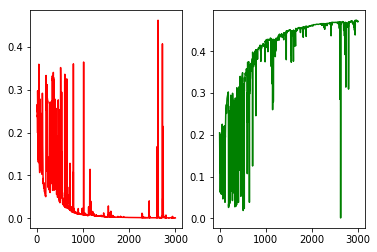

In [38]:
plt.subplot(121)
plt.plot(dlosses,color='red')
plt.subplot(122)
plt.plot(glosses,color='green')
plt.show

# Evaluate Data

In [39]:
with g.as_default():
    gen_audio = Gen(x,_z,reuse=True)

(32, 1, 12, 1024)


In [40]:
x_data,y_data = b.getBatch() #uncomment if not training
fd = {x:x_data,y:y_data} #uncomment if not training
result = sess.run(gen_audio,feed_dict=fd)

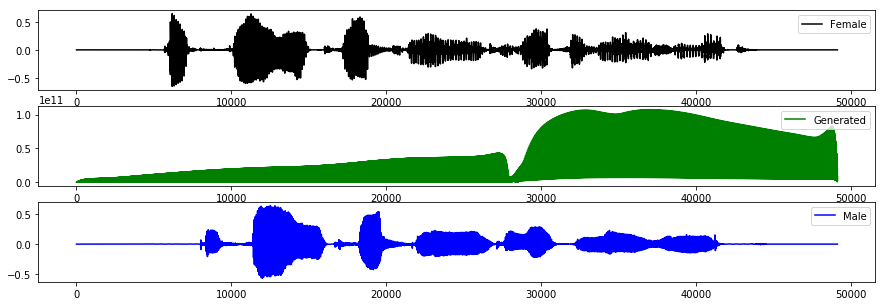

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(311)
plt.plot(x_data[0,0,:,0],color='black')
plt.legend(['Male'])
plt.subplot(312)
plt.plot(result[0,0,:,0],color='green')
plt.legend(['Generated'],loc='upper right')
plt.subplot(313)
plt.plot(y_data[0,0,:,0],color='blue')
plt.legend(['Female'])

In [220]:
for i in g.get_collection('trainable_variables'):
    print i.name

Generator/in/conv1:0
Generator/in/conv2:0
Generator/in/conv3:0
Generator/in/conv4:0
Generator/in/conv5:0
Generator/in/conv6:0
Generator/in/conv7:0
Generator/in/b1:0
Generator/in/b2:0
Generator/in/b3:0
Generator/in/b4:0
Generator/in/b5:0
Generator/in/b6:0
Generator/in/b7:0
Generator/l1/prelu/alpha:0
Generator/l2/prelu/alpha:0
Generator/l3/prelu/alpha:0
Generator/l4/prelu/alpha:0
Generator/l5/prelu/alpha:0
Generator/l6/prelu/alpha:0
Generator/l7/prelu/alpha:0
Generator/out/dconv7:0
Generator/out/dconv6:0
Generator/out/dconv5:0
Generator/out/dconv4:0
Generator/out/dconv3:0
Generator/out/dconv2:0
Generator/out/dconv1:0
Generator/out/b7:0
Generator/out/b6:0
Generator/out/b5:0
Generator/out/b4:0
Generator/out/b3:0
Generator/out/b2:0
Generator/out/b1:0
Generator/out/dl7/bn/gamma:0
Generator/out/dl7/bn/beta:0
Generator/out/dl7/prelu/alpha:0
Generator/out/dl6/bn/gamma:0
Generator/out/dl6/bn/beta:0
Generator/out/dl6/prelu/alpha:0
Generator/out/dl5/bn/gamma:0
Generator/out/dl5/bn/beta:0
Generator

# Write to audio file

In [96]:
#generated
f = open('samples/generated_audio1.wav','wr')
wavfile.write(f,SMP_RATE,result[0,0,:,0].astype(np.int16))
f.close()

In [44]:
#original
f = open('samples/org_audio1.wav','wr')
wavfile.write(f,SMP_RATE,x_data[0,0,:,0].astype(np.int16))
f.close()

In [45]:
#target
f = open('samples/target_audio1.wav','wr')
wavfile.write(f,SMP_RATE,y_data[0,0,:,0].astype(np.int16))
f.close()